# Cora Embeddings



[1]: https://datacrayon.com/posts/programming/python/yaml-for-configuration-files/

In [1]:
%matplotlib inline

import ast

from neo4j import GraphDatabase

import numpy as np
import pandas as pd

import optuna

from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db='testdb'):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [5]:
### Load app configs
import yaml
#with open 'app_configs.yaml' 'rb') as fobj: 
#     config = yaml.load(f, Loader=yaml.FullLoader)
with open("app_configs.yaml", "r") as ymlfile:
    cfg = yaml.load(ymlfile,Loader=yaml.FullLoader)

n4j_uri = cfg['neo4j_uri']
n4j_user= cfg['neo4j_username']    
n4j_pwd = cfg['neo4j_password']

conn = Neo4jConnection(uri=n4j_uri, user=n4j_user, pwd=n4j_pwd)

conn.query("MATCH (n) RETURN COUNT(n)")

[<Record COUNT(n)=20865>]

In [6]:
conn.query("MATCH (n) RETURN COUNT(n)")

[<Record COUNT(n)=20865>]

## Constraints 

In [7]:
# By creating constraints, we are setting up indexing on the ID of the papers. 
# We are also specifying that each paper is unique (based on its ID), thus removing any duplicates that may exist. 
# As a result, graph traversal queries with Cypher can run much faster.

query = """CREATE CONSTRAINT papers IF NOT EXISTS ON (p:Paper) ASSERT p.id IS UNIQUE"""
conn.query(query)

[]

## Node and edge lists

The next two cells populate the nodes and edges (relationships) of the database. The files themselves are discussed in the blog post, and are provided in one of my GitHub repos.



In [8]:
query = """LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/cj2001/pydata2021/main/notebooks/data/cora_nodes.csv' AS line
           WITH line
           MERGE (p:Paper {id: line.id})
               ON CREATE SET p.subject = line.subject, p.features = line.features
           RETURN COUNT(*)
"""

conn.query(query)

[<Record COUNT(*)=2708>]

In [9]:
### Load edges 
query = """LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/cj2001/pydata2021/main/notebooks/data/cora_edges.csv' AS line
           WITH line
           MATCH (source:Paper {id: line.source})
           MATCH (target:Paper {id: line.target})
           MERGE (source)-[:CITES]->(target)
           RETURN COUNT(*)
"""

conn.query(query)

[<Record COUNT(*)=5429>]

## ML Model based on Word Embeddings

We will now create our NLP-based word embedding model. The first cell is just some 
helper functions that will put our graph data into the proper X, y format that 
scikit-learn expects. The following cell runs the SVC model and returns the mean 
accuracy and confusion matrix.


In [10]:
def create_word_df():

    query = """MATCH (p:Paper) RETURN p.id AS id, p.subject AS subject, p.features AS features"""

    df = pd.DataFrame([dict(_) for _ in conn.query(query)])
    df['features'] = df['features'].apply(ast.literal_eval)
    df['embeddings'] = df['features'].apply(lambda x: np.array(x, dtype=float))

    return df


def create_word_X_y(df):

    X = np.array(df['embeddings'].to_list())
    df['target'] = pd.factorize(df['subject'])[0].astype("float32")
    y = df['target'].to_numpy()

    return X, y

In [11]:
def word_modeler(k_folds=5, model='linear', show_matrix=True):

    acc_scores = []

    df = create_word_df()
    X, y = create_word_X_y(df)

    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        clf = svm.SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return



Accuracy scores:  [0.7104874446085672, 0.7045790251107829, 0.7223042836041359, 0.7178729689807977, 0.7370753323485968]
Mean accuracy:  0.7184638109305761


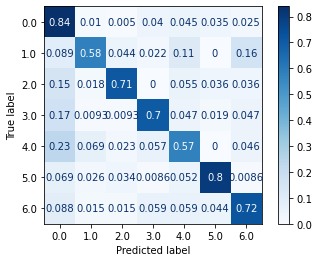

In [12]:
word_modeler()

# ML model based on graph embeddings

The first step in using anything within the GDS library is to create an in-memory graph.  This is described in a bit more detail in the blog post.  However, if you are interested in learning more, you can watch [this video](https://dev.neo4j.com/bites_part12). 

In [13]:
query = """CALL gds.graph.create(
           'cora_graph',
           'Paper',
           {CITES: 
               {
                   orientation: 'UNDIRECTED'
               }
           }
       )
"""

conn.query(query)

Query failed: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.create`: Caused by: java.lang.IllegalArgumentException: A graph with name 'cora_graph' already exists.}


In [14]:
### Creating the model 
### build graph embeddings with default dim size 10 & writing it to graph's nodes. 
def create_embs(dim=10):

    query = """CALL gds.fastRP.write(
               'cora_graph',
               {
                   embeddingDimension: %d,
                   iterationWeights: [0.0, 0.0, 1.0, 1.0],
                   writeProperty: 'fastrp_embedding'
               }
           )
    """ % (dim)

    conn.query(query)
    return

def create_X_y():
    """Create a dataframe: paper id, paper's subject, and fastRP embeddings """

    query = """MATCH (p:Paper) RETURN p.id AS id, p.subject AS subject, p.fastrp_embedding AS fastrp_embedding"""
    emb_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
    display(emb_df.head())
    ### Setting the 'target'
    emb_df['target'] = pd.factorize(emb_df['subject'])[0].astype("float32")
    y = emb_df['target'].to_numpy()
    emb_df['X'] = emb_df['fastrp_embedding'].apply(lambda x: np.array(x))
    X = np.array(emb_df['X'].to_list())

    return X, y



In [15]:
def modeler(dim, k_folds=5, model='linear', show_matrix=True):

    acc_scores = []

    create_embs(dim=dim)
    X, y = create_X_y()

    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        clf = svm.SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return



,id,subject,fastrp_embedding
0,31336,Neural_Networks,"[0.2735336124897003, -0.14014932513237, 0.6108..."
1,1061127,Rule_Learning,"[0.5458564758300781, 0.32021352648735046, -0.2..."
2,1106406,Reinforcement_Learning,"[-0.3909068703651428, -0.735643744468689, 0.84..."
3,13195,Reinforcement_Learning,"[-0.8824717998504639, -0.9107886552810669, 0.4..."
4,37879,Probabilistic_Methods,"[-0.5533919334411621, -0.4746816158294678, 0.0..."


Accuracy scores:  [0.5155096011816839, 0.5361890694239291, 0.5302806499261448, 0.5361890694239291, 0.5361890694239291]
Mean accuracy:  0.5308714918759232


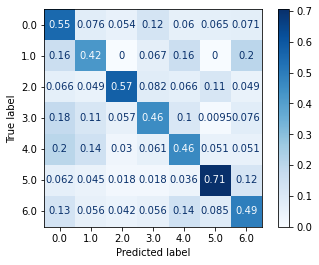

In [16]:
emb_dim_lst = [16, 32, 128, 256]
for edim in emb_dim_lst:
    modeler(dim=edim)
    # 
    print()
    break

## Use of TSNE


### About TSNE 

T-distributed Stochastic Neighbor Embedding. The number of components refers to the dimension of the embedded space.

* popular tool for visualizing high-parameter single-cell data.
* Dimensionality Reduction and explored two of its most popular techniques, Principal Component Analysis and t-Distributed Stochastic Neighbor Embedding [2]. 


[2]: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
[3]: https://www.datacamp.com/community/tutorials/introduction-t-sne


In [17]:
def create_tsne_plot(dim, emb_name='fastrp_embedding'):

    create_embs(dim=dim)
    X, y = create_X_y()

    X_emb = TSNE(n_components=2).fit_transform(X)

    tsne_df = pd.DataFrame(data = {
        'x': [value[0] for value in X_emb],
        'y': [value[1] for value in X_emb], 
        'label': y
    })

    plt.figure(figsize=(16,10))
    s = 30
    ax = sns.scatterplot(
        x='x', y='y',
        palette=sns.color_palette('hls', 7),
        data=tsne_df,
        hue='label',
        legend=True, 
        s=100,
        alpha=0.75
    )
    ax.legend(prop={'size': 10})
    plt.xlabel('X Component', fontsize=16)
    plt.ylabel('Y Component', fontsize=16)
    plt.show
    
    return tsne_df

In [ ]:
tsne_df = create_tsne_plot(dim=16)

,id,subject,fastrp_embedding
0,31336,Neural_Networks,"[-0.016671957448124886, 0.5850130319595337, -0..."
1,1061127,Rule_Learning,"[-0.051147133111953735, -0.15641461312770844, ..."
2,1106406,Reinforcement_Learning,"[-0.021324288100004196, -0.4195905327796936, -..."
3,13195,Reinforcement_Learning,"[-0.1478549987077713, -0.6204941272735596, 0.0..."
4,37879,Probabilistic_Methods,"[0.40031135082244873, 0.1639956831932068, -0.2..."
